In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from write_submission import write_submission

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [2]:
def loadTrainData(path='../data/train.csv'):
    df = pd.read_csv(path)
    return df.drop(['From_Cache_la_Poudre','ID','Soil_Type'], axis=1), df['From_Cache_la_Poudre']

def loadTestData(path='../data/test.csv'):
    df = pd.read_csv(path)
    return df.drop(['ID','Soil_Type'],axis=1), df["ID"]

def l2distance(x, y):
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    m = x.shape[0] # x has shape (m, d)
    n = y.shape[0] # y has shape (n, d)
    x2 = np.sum(x**2, axis=1).reshape((m, 1))
    y2 = np.sum(y**2, axis=1).reshape((1, n))
    xy = x.dot(y.T) # shape is (m, n)
    dists = np.sqrt(x2 + y2 - 2*xy) # shape is (m, n)
    return dists

In [30]:
# Load data
X, y = loadTrainData()
X, y = X.values, y.values

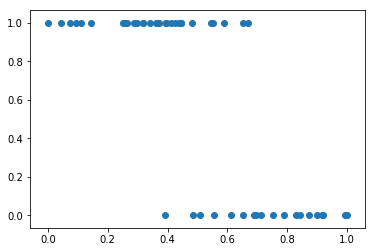

In [31]:
# 1-D experimentation set
Xa, ya = X[:50, 0], y[:50].reshape(-1, 1)
Xmin = np.min(Xa)
Xmax = np.max(Xa)
Xa = np.divide(Xa - Xmin, Xmax - Xmin)
plt.scatter(Xa, ya)
# Xa = np.array([0.00471885619097257,
# 0.121569120783114,
# 0.186706589684953,
# 0.278369385093796,
# 0.424517590749133,
# 0.543404941790965,
# 0.575093329427250,
# 0.670749084726779,
# 0.825852755105048,
# 0.894776132319904])
# ya = np.array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]).reshape(-1, 1)

In [32]:
# Covariance parameters
gamma = 10
alpha = 10
N = len(ya)

In [33]:
# Compute covariance for training data.
C = alpha * np.exp(-gamma * l2distance(Xa, Xa)**2)

In [34]:
# Newton-Raphson procedure for finding f.
f = np.zeros((N, 1))
invC = np.linalg.pinv(C)

In [35]:
max_its = 10
allf = np.zeros((max_its, N))
allf[0, :] = f.T
for it in range(max_its - 1):
    g = np.divide(1, (1 + np.exp(-f)))
    gradient = np.dot(-invC, f) + ya - g
    hessian = -invC - np.diagflat(g * (1-g))
    f -= np.dot(np.linalg.pinv(hessian), gradient)
    allf[it+1, :] = f.T
hessian = -invC - np.diag(g * (1-g))

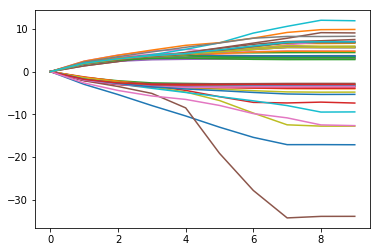

In [36]:
a = plt.plot(allf)

In [37]:
# Predictions with the point estimate
testx = np.linspace(0, 1, 101).reshape(-1, 1)
Ntest = len(testx)

In [38]:
# Covariance functions
R = alpha * np.exp(-gamma * l2distance(Xa, testx)**2)
Cstar = alpha * np.exp(-gamma * l2distance(testx, testx)**2)

# Latent function
fs = np.dot(np.dot(R.T, invC), f)

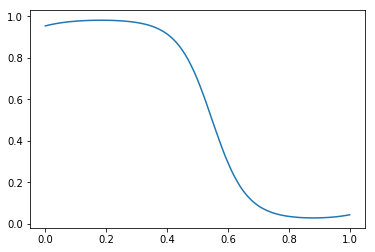

In [42]:
# Plot the predictive latent function.
# plt.plot(testx, fs)
# plt.scatter(Xa, f)

# Plot the predictive probabilities
plt.plot(testx, 1/(1 + np.exp(-fs)))

In [ ]:
# Test predictions